## 第一种方法直接用keras的fit方法，以fashion mnist为例

In [1]:
import tensorflow as tf
import time
import datetime
import matplotlib
matplotlib.use("Agg")#这个设置可以使matplotlib保存.png图到磁盘
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import pandas as pd
import os
import shutil
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
#jupyter 中开启该选项，否则不执行
%matplotlib inline 

### 配置超参数

In [3]:
batch_size=64
epochs=6
regularizer=1e-3
total_train_samples=60000
total_test_samples=10000
lr_decay_epochs=1
output_folder="./model_output_hdf5"
if os.path.exists(output_folder):
    inc=input("The model saved path has exist,Do you want to delete and remake it?(y/n)")
    while(inc.lower() not in ['y','n']):
        inc=input("The model saved path has exist,Do you want to delete and remake it?(y/n)")
    if inc.lower()=='y':
        shutil.rmtree(output_folder)
#用来保存模型以及我们需要的所有东西
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
save_format="hdf5" #或saved_model
if save_format=="hdf5":
    save_path_models=os.path.join(output_folder,"hdf5_models")
    if not os.path.exists(save_path_models):
        os.makedirs(save_path_models)
    save_path=os.path.join(save_path_models,"ckpt_epoch{epoch:02d}_val_acc{val_accuracy:.2f}.hdf5")
elif save_format=="saved_model":
    save_path_models=os.path.join(output_folder,"saved_models")
    if not os.path.exists(save_path_models):
        os.makedirs(save_path_models)
    save_path=os.path.join(save_path_models,"ckpt_epoch{epoch:02d}_val_acc{val_accuracy:.2f}.ckpt")
#用来保存日志
log_dir= os.path.join(output_folder,'logs_{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

The model saved path has exist,Do you want to delete and remake it?(y/n)
The model saved path has exist,Do you want to delete and remake it?(y/n)y


### 选择指定显卡及自动调用显存

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')#列出所有可见显卡
print("All the available GPUs:\n",physical_devices)
if physical_devices:
    gpu=physical_devices[0]#显示第一块显卡
    tf.config.experimental.set_memory_growth(gpu, True)#根据需要自动增长显存
    tf.config.experimental.set_visible_devices(gpu, 'GPU')#只选择第一块

All the available GPUs:
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 准备数据

In [5]:
fashion_mnist=tf.keras.datasets.fashion_mnist
(train_x,train_y),(test_x,test_y)=fashion_mnist.load_data()

train_x,test_x = train_x[...,np.newaxis]/255.0,test_x[...,np.newaxis]/255.0
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 使用tf.data来准备训练集和测试集

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x,train_y))
test_ds = tf.data.Dataset.from_tensor_slices((test_x,test_y))
 
train_ds=train_ds.shuffle(buffer_size=batch_size*10).batch(batch_size).prefetch(buffer_size = tf.data.experimental.AUTOTUNE).repeat()
test_ds = test_ds.batch(batch_size).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)#不加repeat，执行一次就行

### 准备模型定义

In [7]:
l2 = tf.keras.regularizers.l2(regularizer)#定义模型正则化方法
ini = tf.keras.initializers.he_normal()#定义参数初始化方法
conv2d = partial(tf.keras.layers.Conv2D,activation='relu',padding='same',kernel_regularizer=l2,bias_regularizer=l2)
fc = partial(tf.keras.layers.Dense,activation='relu',kernel_regularizer=l2,bias_regularizer=l2)
maxpool=tf.keras.layers.MaxPooling2D
dropout=tf.keras.layers.Dropout


### 开始定义模型,用functional方法

In [8]:
x_input = tf.keras.layers.Input(shape=(28,28,1),name='input_node')
x = conv2d(128,(5,5))(x_input)
x = maxpool((2,2))(x)
x = conv2d(256,(5,5))(x)
x = maxpool((2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = fc(128)(x)
x_output=fc(10,activation=None,name='output_node')(x)
model = tf.keras.models.Model(inputs=x_input,outputs=x_output)                


### 打印模型结构

In [9]:
print("The model architure:\n")
print(model.summary())

The model architure:

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_node (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 256)       819456    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128

### 画出模型结构图并保存

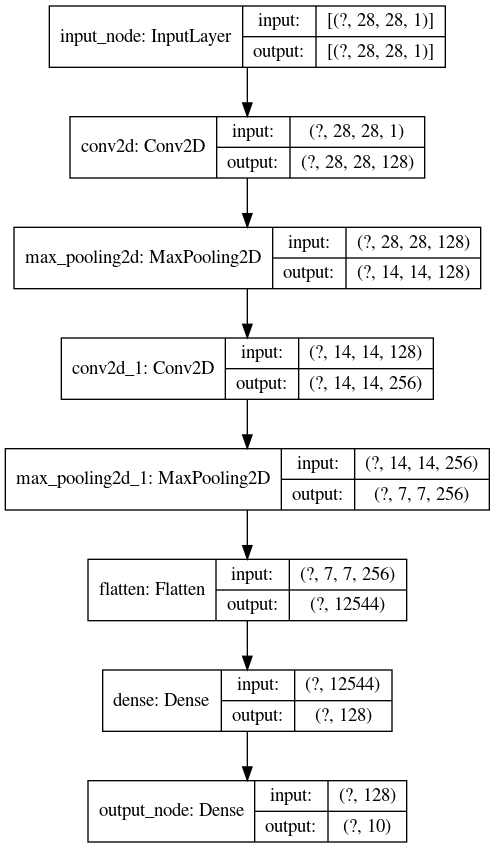

In [10]:
tf.keras.utils.plot_model(model,to_file=os.path.join(log_dir,'model.png'),show_shapes=True,show_layer_names=True)

### 定义优化算法和损失函数

In [11]:
#学习率变化设置，使用指数衰减
train_steps_per_epoch=int(total_train_samples//batch_size)
initial_learning_rate=0.01
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
#                                                              decay_steps=1*train_steps_per_epoch,
#                                                             decay_rate=0.96,
#                                                             staircase=True)#initial_learning_rate*0.96**(step/decay_steps)
#优化算法
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate,momentum=0.95)
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.95)
#损失函数
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#评价指标
# metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),loss]
metrics=['accuracy','sparse_categorical_crossentropy']
#上式第二个参数会返回交叉熵的结果，用loss减去该值就会得到正则化的值（于model.losses和相等），这两种定义方式都可以，下边的会显示名称短一些



### 编译模型

In [12]:
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

### 定义callbacks

#### 1、生成ckpt每个epoch训练完保存一个模型

In [13]:
#模型保存格式默认是saved_model,可以自己定义更改原有类来保存hdf5
ckpt = tf.keras.callbacks.ModelCheckpoint(save_path,monitor='val_accuracy',verbose=1,
                                         save_best_only=False,save_weights_only=False,
                                         save_frequency=1)#参数具体函意，查看官方文档


#### 2、当模型验证集精度长时间不再提升时停止训练

In [14]:
#当模型训练不符合我们要求时停止训练，连续5个epoch验证集精度没有提高0.001%停
earlystop=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta = 0.1,patience=1,verbose=True)

#### 3、自定义学习率按需衰减，并把整个学习率变化过程保存

In [15]:
class LearningRateExponentialDecay:
    def __init__(self,initial_learning_rate,decay_epochs,decay_rate):
        self.initial_learning_rate=initial_learning_rate
        self.decay_epochs=decay_epochs
        self.decay_rate=decay_rate
    def __call__(self,epoch):
        dtype =type(self.initial_learning_rate)
        decay_epochs=np.array(self.decay_epochs).astype(dtype)
        decay_rate=np.array(self.decay_rate).astype(dtype)
        epoch = np.array(epoch).astype(dtype)
        p = epoch/decay_epochs
        lr = self.initial_learning_rate*np.power(decay_rate,p)
        return lr
lr_schedule=LearningRateExponentialDecay(initial_learning_rate,lr_decay_epochs,0.96)
lr = tf.keras.callbacks.LearningRateScheduler(lr_schedule,verbose=1)

#### 4、使用tensorboard

In [16]:
#还要加入tensorboard的使用,这种方法记录的内容有限
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

#### 5、loss中出现nan或inf时停止训练

In [17]:
#定义当loss出现nan或inf时停止训练的callback
terminate=tf.keras.callbacks.TerminateOnNaN()

#### 6、模型损失长时间不除时大程度降低学习率

In [18]:
#降低学习率（要比学习率自动周期变化有更大变化和更长时间监控）
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,min_delta=0.0001,min_lr=0)

#### 7、保存训练过程中所有标量指标

In [19]:
#保存训练过程中大数标量指标，与tensorboard同一个文件
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(log_dir,'logs.log'),separator=',')

### 综合所有的callbacks

In [20]:
callbacks=[ckpt,earlystop,lr,tensorboard,terminate,reduce_lr,csv_logger]

### 开始训练模型

In [22]:
# H=model.fit(train_ds,epochs=epochs,steps_per_epoch=len(train_x)//batch_size,validation_data=test_ds)
H=model.fit(train_ds,epochs=epochs,
            steps_per_epoch=len(train_x)//batch_size,
            validation_data=test_ds,
            validation_steps=int(len(test_x)//batch_size)+1,
            callbacks=callbacks,verbose=1)

Train for 937 steps, validate for 157 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/6
936/937 [============================>.] - ETA: 0s - loss: 0.5590 - accuracy: 0.8820 - sparse_categorical_crossentropy: 1.2380
Epoch 00001: saving model to ./model_output_hdf5/hdf5_models/ckpt_epoch01_val_acc0.89.hdf5
937/937 [==============================] - 76s 81ms/step - loss: 0.5589 - accuracy: 0.8821 - sparse_categorical_crossentropy: 1.2383 - val_loss: 0.5101 - val_accuracy: 0.8864 - val_sparse_categorical_crossentropy: 1.2210

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0096.
Epoch 2/6
936/937 [============================>.] - ETA: 0s - loss: 0.4576 - accuracy: 0.8947 - sparse_categorical_crossentropy: 1.1965
Epoch 00002: saving model to ./model_output_hdf5/hdf5_models/ckpt_epoch02_val_acc0.88.hdf5
937/937 [==============================] - 76s 82ms/step - loss: 0.4575 - accuracy: 0.8947 - sparse_categorical_crossentropy: 1.1965 - val_lo

In [22]:
callbacks=[ckpt,earlystop,lr,tensorboard,reduce_lr,csv_logger]
H=model.fit(train_ds,epochs=epochs,steps_per_epoch=len(train_x)//batch_size,validation_data=test_ds,callbacks=callbacks,verbose=1)

Train for 937 steps, validate for 157 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
936/937 [============================>.] - ETA: 0s - loss: 0.5561 - accuracy: 0.8809 - sparse_categorical_crossentropy: 1.2742
Epoch 00001: saving model to ./model_output/hdf5_models/ckpt_epoch01_val_acc0.87.hdf5
937/937 [==============================] - 76s 82ms/step - loss: 0.5562 - accuracy: 0.8808 - sparse_categorical_crossentropy: 1.2741 - val_loss: 0.5322 - val_accuracy: 0.8739 - val_sparse_categorical_crossentropy: 1.2254


In [23]:
callbacks=[ckpt,earlystop,lr,tensorboard,reduce_lr]
H=model.fit(train_ds,epochs=epochs,steps_per_epoch=len(train_x)//batch_size,validation_data=test_ds,callbacks=callbacks,verbose=1)

Train for 937 steps, validate for 157 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
936/937 [============================>.] - ETA: 0s - loss: 0.4535 - accuracy: 0.8951 - sparse_categorical_crossentropy: 1.2246
Epoch 00001: saving model to ./model_output/hdf5_models/ckpt_epoch01_val_acc0.90.hdf5
937/937 [==============================] - 76s 81ms/step - loss: 0.4535 - accuracy: 0.8951 - sparse_categorical_crossentropy: 1.2248 - val_loss: 0.4338 - val_accuracy: 0.8965 - val_sparse_categorical_crossentropy: 1.1898


In [25]:
callbacks=[ckpt,earlystop,lr,tensorboard]
H=model.fit(train_ds,epochs=epochs,steps_per_epoch=len(train_x)//batch_size,validation_data=test_ds,callbacks=callbacks,verbose=1)

Train for 937 steps, validate for 157 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
936/937 [============================>.] - ETA: 0s - loss: 0.4035 - accuracy: 0.9024 - sparse_categorical_crossentropy: 1.1825
Epoch 00001: saving model to ./model_output/hdf5_models/ckpt_epoch01_val_acc0.89.hdf5
937/937 [==============================] - 76s 81ms/step - loss: 0.4035 - accuracy: 0.9023 - sparse_categorical_crossentropy: 1.1825 - val_loss: 0.4278 - val_accuracy: 0.8901 - val_sparse_categorical_crossentropy: 1.1874


In [26]:
callbacks=[ckpt,earlystop,lr]
H=model.fit(train_ds,epochs=epochs,steps_per_epoch=len(train_x)//batch_size,validation_data=test_ds,callbacks=callbacks,verbose=1)

Train for 937 steps, validate for 157 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
936/937 [============================>.] - ETA: 0s - loss: 0.3807 - accuracy: 0.9073 - sparse_categorical_crossentropy: 1.1501
Epoch 00001: saving model to ./model_output/hdf5_models/ckpt_epoch01_val_acc0.90.hdf5
937/937 [==============================] - 76s 82ms/step - loss: 0.3807 - accuracy: 0.9073 - sparse_categorical_crossentropy: 1.1500 - val_loss: 0.3924 - val_accuracy: 0.9013 - val_sparse_categorical_crossentropy: 1.1530


In [27]:
callbacks=[ckpt,earlystop]
H=model.fit(train_ds,epochs=epochs,steps_per_epoch=len(train_x)//batch_size,validation_data=test_ds,callbacks=callbacks,verbose=1)

Train for 937 steps, validate for 157 steps
936/937 [============================>.] - ETA: 0s - loss: 0.3670 - accuracy: 0.9109 - sparse_categorical_crossentropy: 1.1360
Epoch 00001: saving model to ./model_output/hdf5_models/ckpt_epoch01_val_acc0.90.hdf5
937/937 [==============================] - 76s 82ms/step - loss: 0.3671 - accuracy: 0.9108 - sparse_categorical_crossentropy: 1.1360 - val_loss: 0.3853 - val_accuracy: 0.9035 - val_sparse_categorical_crossentropy: 1.1400


In [28]:
callbacks=[ckpt]
H=model.fit(train_ds,epochs=epochs,steps_per_epoch=len(train_x)//batch_size,validation_data=test_ds,callbacks=callbacks,verbose=1)

Train for 937 steps, validate for 157 steps
936/937 [============================>.] - ETA: 0s - loss: 0.3592 - accuracy: 0.9132 - sparse_categorical_crossentropy: 1.1203
Epoch 00001: saving model to ./model_output/hdf5_models/ckpt_epoch01_val_acc0.90.hdf5
937/937 [==============================] - 76s 82ms/step - loss: 0.3592 - accuracy: 0.9132 - sparse_categorical_crossentropy: 1.1203 - val_loss: 0.3935 - val_accuracy: 0.9030 - val_sparse_categorical_crossentropy: 1.1504


In [29]:
a=time.time()

H=model.fit(train_ds,epochs=epochs,steps_per_epoch=len(train_x)//batch_size,validation_data=test_ds,verbose=1)
b=time.time()-a
print(b)

Train for 937 steps, validate for 157 steps
937/937 [==============================] - 76s 81ms/step - loss: 0.3560 - accuracy: 0.9147 - sparse_categorical_crossentropy: 1.1174 - val_loss: 0.3850 - val_accuracy: 0.9047 - val_sparse_categorical_crossentropy: 1.1262
76.25723671913147


### 画学习率变化曲线并保存到log中

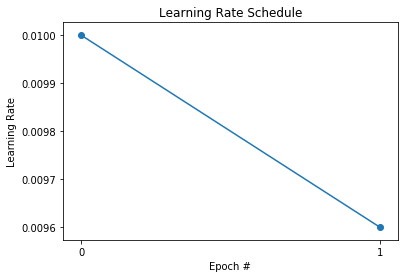

In [31]:
def plot(lrs,title="Learning Rate Schedule"):
    #计算学习率随epoch的变化值

        epochs=np.arange(len(lrs))
        plt.figure()
        plt.plot(epochs,lrs)
        plt.xticks(epochs)
        plt.scatter(epochs,lrs)
        plt.title(title)
        plt.xlabel("Epoch #")
        plt.ylabel("Learning Rate")
plot(H.history['lr'])
# plt.savefig(os.path.join(log_dir,'learning_rate.png'))

<class '__main__.LearningRateExponentialDecay'>


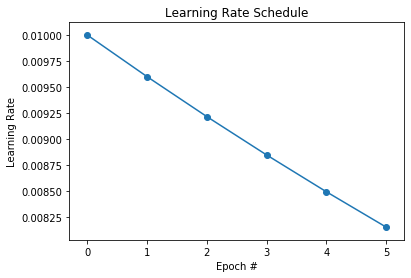

In [29]:
N = np.arange(epochs)
lr_schedule.plot(N)
plt.savefig(os.path.join(log_dir,'learning_rate.png'))

### 画模型训练及验证loss和acc曲线

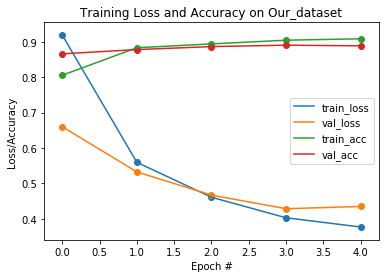

In [23]:
plt.figure()
plt.plot(N,H.history['loss'],label='train_loss')
plt.scatter(N,H.history['loss'])
plt.plot(N,H.history['val_loss'],label='val_loss')
plt.scatter(N,H.history['val_loss'])
plt.plot(N,H.history['accuracy'],label='train_acc')
plt.scatter(N,H.history['accuracy'])
plt.plot(N,H.history['val_accuracy'],label='val_acc')
plt.scatter(N,H.history['val_accuracy'])
plt.title('Training Loss and Accuracy on Our_dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.savefig(os.path.join(log_dir,'training.png'))

关于上图中epoch=0,随机初始化参数在验证集上精度远高于训练集的原因，将来其它博客中说明。

### 保存模型结构及配置参数

In [24]:
model_json = model.to_json()
with open(os.path.join(log_dir,'model_json.json'),'w') as json_file:
    json_file.write(model_json)

### 对模型在测试集上进行评估

In [25]:
metrics=model.evaluate(test_ds,verbose=1)
print("val_loss:",metrics[0],"val_accuracy:",metrics[1])

157/157 [==============================] - 4s 26ms/step - loss: 0.4350 - accuracy: 0.8884 - sparse_categorical_crossentropy: 1.2115
val_loss: 0.43501977328282254 val_accuracy: 0.8884


### 对模型进行推理并分析推理结果

In [26]:
predictions=model.predict(test_ds,verbose=1)

157/157 [==============================] - 4s 24ms/step


In [27]:
def print_metrics(labels, predictions,target_names,save=False,save_path=None):
    # 计算confusion result
    preds=np.argmax(predictions,axis=-1)
    confusion_result = confusion_matrix(labels, preds)
    pd.set_option('display.max_rows', 500)
    
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 1500)
    confusion_result = pd.DataFrame(confusion_result, index = target_names, columns = target_names)
    # classification report
    report = classification_report(labels, preds, target_names = target_names, digits = 4)
    result_report = 'Confuse_matrix:\n{}\n\nClassification_report:\n{} \n'.format(confusion_result, report)
    print(result_report)
    if save:   

        savepath = os.path.join(save_path,"predicted_result.txt")

        print('the result saved in %s' % savepath)#如果savepath相同的话,会把所有结果保存到同一个文件中

        with open(savepath, 'w') as f:
            f.write(result_report)


In [28]:
print_metrics(test_y,predictions,class_names,True,log_dir)

Confuse_matrix:
             T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  Sneaker  Bag  Ankle boot
T-shirt/top          956        0        15     10     3       1      5        0   10           0
Trouser                4      982         0     10     2       0      0        0    2           0
Pullover              24        2       897      8    53       0     12        0    4           0
Dress                 44        6        13    903    23       0      7        0    4           0
Coat                   3        1        94     29   853       0     18        0    2           0
Sandal                 0        0         0      0     0     978      0        8    0          14
Shirt                325        2       122     18   101       0    420        0   12           0
Sneaker                0        0         0      0     0      17      0      928    1          54
Bag                    4        1         2      2     1       1      0        2  987           0
Ankl

### 显示输出文件结构

In [29]:
%%bash
tree model_output

model_output
├── hdf5_models
│   ├── ckpt_epoch01_val_acc0.87.hdf5
│   ├── ckpt_epoch02_val_acc0.88.hdf5
│   ├── ckpt_epoch03_val_acc0.89.hdf5
│   ├── ckpt_epoch04_val_acc0.89.hdf5
│   └── ckpt_epoch05_val_acc0.89.hdf5
└── logs_20191121-132954
    ├── learning_rate.png
    ├── logs.log
    ├── model_json.json
    ├── model.png
    ├── predicted_result.txt
    ├── train
    │   ├── events.out.tfevents.1574314212.ubuntu.7877.401.v2
    │   ├── events.out.tfevents.1574314215.ubuntu.profile-empty
    │   └── plugins
    │       └── profile
    │           └── 2019-11-21_13-30-15
    │               └── local.trace
    ├── training.png
    └── validation
        └── events.out.tfevents.1574314291.ubuntu.7877.5942.v2

7 directories, 15 files


### 同样，只改变保存类型为ckpt

In [29]:
%%bash
tree model_output

model_output
├── logs_20191121-130455
│   ├── learning_rate.png
│   ├── logs.log
│   ├── model_json.json
│   ├── model.png
│   ├── predicted_result.txt
│   ├── train
│   │   ├── events.out.tfevents.1574312711.ubuntu.7321.401.v2
│   │   ├── events.out.tfevents.1574312713.ubuntu.profile-empty
│   │   └── plugins
│   │       └── profile
│   │           └── 2019-11-21_13-05-13
│   │               └── local.trace
│   ├── training.png
│   └── validation
│       └── events.out.tfevents.1574312790.ubuntu.7321.7346.v2
├── logs_20191121-131145
│   ├── logs.log
│   ├── model.png
│   └── train
│       ├── events.out.tfevents.1574313110.ubuntu.7470.401.v2
│       ├── events.out.tfevents.1574313113.ubuntu.profile-empty
│       └── plugins
│           └── profile
│               └── 2019-11-21_13-11-53
│                   └── local.trace
├── logs_20191121-131222
│   ├── learning_rate.png
│   ├── logs.log
│   ├── model_json.json
│   ├── model.png
│   ├── predicted_result.txt
│   ├── train
│   │   ├── 